In [6]:
%pip uninstall keras -y  
%pip install tf-keras 

Found existing installation: keras 3.9.2
Uninstalling keras-3.9.2:
  Successfully uninstalled keras-3.9.2
Note: you may need to restart the kernel to use updated packages.
  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 23.6 MB/s eta 0:00:00
Using cached keras-3.9.2-py3-none-any.whl (1.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [10]:
# Load dataset
df = pd.read_csv('../../data/raw/IMDB Dataset.csv')

# Convert sentiment to binary (0: negative, 1: positive)
df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split data (80% train, 10% validation, 10% test)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 40000
Validation size: 5000
Test size: 5000


In [11]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize a sample review to see how it works
sample_text = "This movie was great! Loved the acting."
tokens = tokenizer(sample_text, padding='max_length', truncation=True, max_length=128)
print("Tokenized sample:", tokens)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\adity\.conda\envs\rawat\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\adity\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenized sample: {'input_ids': [101, 2023, 3185, 2001, 2307, 999, 3866, 1996, 3772, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [12]:
def convert_to_bert_input(texts, labels, max_length=128):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return {
        'input_ids': np.array(input_ids),
        'attention_mask': np.array(attention_masks),
        'labels': np.array(labels)
    }

# Apply to train, validation, and test sets
train_data = convert_to_bert_input(train_df['review'].tolist(), train_df['label'].tolist())
val_data = convert_to_bert_input(val_df['review'].tolist(), val_df['label'].tolist())
test_data = convert_to_bert_input(test_df['review'].tolist(), test_df['label'].tolist())

In [13]:
# Load pre-trained BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=3,  # BERT converges quickly
    batch_size=16
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3

2500/2500 [==============================] - 13442s 5s/step - loss: 0.3112 - accuracy: 0.8662 - val_loss: 0.2595 - val_accuracy: 0.8936
Epoch 2/3
2500/2500 [==============================] - 14114s 6s/step - loss: 0.1841 - accuracy: 0.9281 - val_loss: 0.2631 - val_accuracy: 0.8928
Epoch 3/3
2500/2500 [==============================] - 10272s 4s/step - loss: 0.0971 - accuracy: 0.9648 - val_loss: 0.3429 - val_accuracy: 0.8900


157/157 [==============================] - 466s 3s/step - loss: 0.3521 - accuracy: 0.8918
Test Accuracy: 0.8918


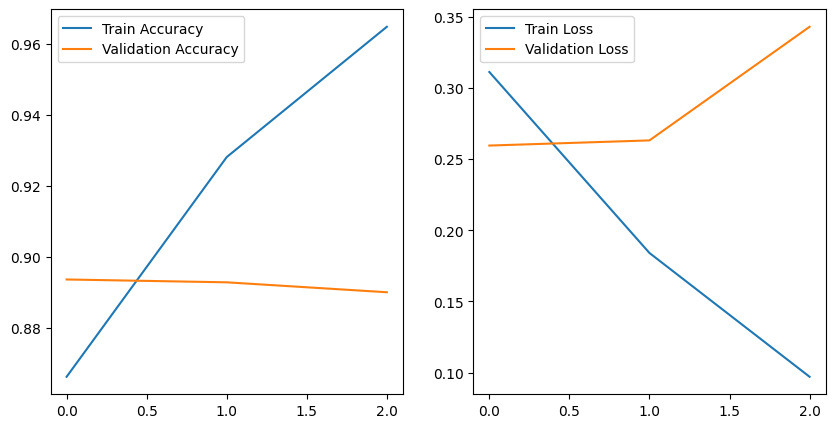

In [14]:
# Evaluate on test data
results = model.evaluate(test_data)
print(f"Test Accuracy: {results[1]:.4f}")

# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [15]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="tf", padding=True, truncation=True, max_length=128)
    outputs = model(inputs)
    logits = outputs.logits
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]
    sentiment = "positive" if predicted_class == 1 else "negative"
    confidence = tf.nn.softmax(logits, axis=1).numpy()[0][predicted_class]
    return sentiment, confidence

# Test prediction
sample_review = "This movie was fantastic! The acting was brilliant."
sentiment, confidence = predict_sentiment(sample_review)
print(f"Predicted Sentiment: {sentiment} (Confidence: {confidence:.2f})")

Predicted Sentiment: positive (Confidence: 0.99)


In [17]:
# Save the model
model.save_pretrained("best_bert_model")

# Load the model later
loaded_model = TFBertForSequenceClassification.from_pretrained("best_bert_model")

Some layers from the model checkpoint at best_bert_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at best_bert_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
